In [3]:
import numpy as np
import stdatamodels.jwst.datamodels as dm
import matplotlib.pyplot as plt
import os

os.environ['CRDS_PATH'] = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS/"
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

from glob import glob
from astropy.visualization import ZScaleInterval
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.widgets import Slider

from jwst.pipeline import Spec2Pipeline, Spec3Pipeline, Detector1Pipeline
from BNBG.utils import getSourcePosition

directory = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/TestSingleSlit/"

# Keep only one source for faster tests

In [ ]:
def keepOnlySource(model, srcid):
	slits = []
	for i in range(len(model.slits)):
		_ = model.slits.pop(0)
		if _.source_id == srcid:
			slits.append(_)

	for slit in slits:
		model.slits.append(slit)
	return model

In [ ]:
msa = fits.open(directory + "jw01345063001_01_msa.fits")

msa[2].data = msa[2].data[msa[2].data["source_id"] == 22800]
msa[3].data = msa[3].data[msa[3].data["source_id"] == 22800]

msa.writeto(directory + "jw01345063001_01_msa.fits", overwrite=True)


# Det 1 Stage

In [ ]:
uncal_list = glob(directory + "*_uncal.fits")

for uncal in uncal_list:
	steps = {
                    'jump': {'expand_large_events': True,
                             # 1st flag groups after jump above DN threshold.
                             'after_jump_flag_dn1': 0,
                             # 1st flag groups after jump groups within
                             # specified time.
                             'after_jump_flag_time1': 0,
                             # 2nd flag groups after jump above DN threshold.
                             'after_jump_flag_dn2': 0,
                             # 2nd flag groups after jump groups within
                             # specified time.
                             'after_jump_flag_time2': 0,
                             # Minimum required area for the central saturation
                             # of snowballs.
                             'min_sat_area': 15.0,
                             # Minimum area to trigger large events processing.
                             'min_jump_area': 15.0,
                             # The expansion factor for the enclosing circles
                             # or ellipses.
                             'expand_factor': 20.0},
                }
	det1 = Detector1Pipeline(steps=steps)
	for step in det1.steps:
		getattr(det1, step).save_results = True
	det1.output_dir = directory + "Stage1/"
	det1.save_results = True
	det1.run(uncal)

In [ ]:
det1_files = glob(directory + "Stage1/*")
det1_files.sort(key=os.path.getmtime)
datalist = []

ylim = (1567, 1992)
xlim = (386, 411)

for file in det1_files:
	file = fits.open(file)

	if len(file[1].data.shape) == 2:
		data = file[1].data[xlim[0]:xlim[1], ylim[0]:ylim[1]]

	if len(file[1].data.shape) == 3:
		data = file[1].data[0, xlim[0]:xlim[1], ylim[0]:ylim[1]]

	if len(file[1].data.shape) == 4:
		data = file[1].data[0, 13, xlim[0]:xlim[1], ylim[0]:ylim[1]]

	z1,z2 = ZScaleInterval().get_limits(data)
	plt.figure(figsize=(10, 2))
	plt.subplot(211)
	plt.imshow(data, cmap="plasma", vmin=z1, vmax=z2)
	plt.title(os.path.basename(file.filename())[31:])

	if len(datalist) > 0:
		residual = data - datalist[-1]
		z1,z2 = ZScaleInterval().get_limits(residual)
		plt.subplot(212)
		plt.imshow(residual, cmap="seismic", vmin=z1, vmax=z2)

	plt.show()
	datalist.append(data)

	file.close()

In [ ]:
from jwst.jump import JumpStep

dark = [_ for _ in det1_files if "dark_current" in _][0]
dark = dm.open(dark)

In [ ]:
jump = JumpStep()
jump.expand_large_events = True
jump.after_jump_flag_dn1 = 0
jump.after_jump_flag_time1 = 0
jump.after_jump_flag_dn2 = 0
jump.after_jump_flag_time2 = 0
jump.min_sat_area = 15.0
jump.min_jump_area = 15.0
jump.expand_factor = 20.0
j = jump.run(dark)

plt.figure(figsize=(14, 2))
_ = dm.open([_ for _ in det1_files if "jump" in _][0])
data1 = _.data[0,13,xlim[0]:xlim[1], ylim[0]:ylim[1]]
z1,z2 = ZScaleInterval().get_limits(data1)
plt.imshow(data1, cmap="plasma", vmin=z1, vmax=z2, interpolation='none')
plt.show()

plt.figure(figsize=(14, 2))
data2 = j.data[0,13,xlim[0]:xlim[1], ylim[0]:ylim[1]]
z1,z2 = ZScaleInterval().get_limits(data2)
plt.imshow(data2, cmap="plasma", vmin=z1, vmax=z2, interpolation='none')
plt.show()

plt.figure(figsize=(14, 2))
data = data1 - data2
z1,z2 = ZScaleInterval().get_limits(data)
plt.imshow(data, cmap="seismic", vmin=z1, vmax=z2, interpolation='none')
plt.show()



# Treat both with and without subtraction

In [ ]:
uncal_list = glob(directory + "*_uncal.fits")

for uncal in uncal_list:
	det1 = Detector1Pipeline()
	det1.output_dir = directory
	det1.save_results = True
	det1.run(uncal)

In [ ]:
asn_list = glob(directory + "*spec2*asn*")
for asn in asn_list:
	steps = {"bkg_subtract" : {"skip":True},
			 "flat_field" : {"save_interpolated_flat" : True, "save_results": True},
			 "badpix_selfcal" : {"skip":False, "save_results": True},
			 "pathloss" : {"save_results": True}}
	spec2 = Spec2Pipeline(steps=steps)
	spec2.output_dir = directory + "NoSub/"
	spec2.save_results = True
	spec2.run(asn)

	steps = {"bkg_subtract" : {"skip":False},
			 "flat_field" : {"save_interpolated_flat" : True},
			 "badpix_selfcal" : {"skip":False}}
	spec2 = Spec2Pipeline(steps=steps)
	spec2.output_dir = directory + "Default/"
	spec2.save_results = True
	spec2.run(asn)

for folder in ["Default/", "NoSub/"]:
	asn = directory + folder + "jw01345-o063_20241001t101453_spec3_00001_asn.json"
	steps = {"resample_spec": {"weight_type" : "exptime"}}
	spec3 = Spec3Pipeline()
	spec3.output_dir = directory + folder
	spec3.save_results = True
	spec3.run(asn)

# Read output logs

In [ ]:
def removeDate(input_file):
	with open(input_file, "r") as file:
		lines = file.readlines()

	# Process the lines
	processed_lines = []
	for line in lines:
		if "stpipe." in line:
			truncated_line = line.split("stpipe.", 1)[1]  # Keep everything after "stpipe."
			truncated_line = "stpipe." + truncated_line  # Add "stpipe." back at the beginning
			processed_lines.append(truncated_line)
		else:
			processed_lines.append(line)  # Keep lines unchanged if "stpipe." not found

	# Write the processed lines to a new file
	with open(input_file, "w") as file:
		file.writelines(processed_lines)

removeDate(directory+"nosub.log")
removeDate(directory+"default.log")


In [ ]:
import difflib

with open(directory+"nosub.log", "r") as f1, open(directory+"default.log", "r") as f2:
	lines1 = f1.readlines()
	lines2 = f2.readlines()

# Use difflib to compare the lines
differ = difflib.unified_diff(lines1, lines2, lineterm="", n=0)

# Print the differences
print("Differences between the files:")
for line in differ:
	if "@@" in line:
		print("\n")
	print(line.strip())


# Compare both stage 2 cal files

In [ ]:
nosub = dm.open(directory + "NoSub/jw01345063001_03101_00001_nrs1_s2d.fits").slits[0].data
default = dm.open(directory + "Default/jw01345063001_03101_00001_nrs1_s2d.fits").slits[0].data

print(np.nanmin(nosub), np.nanmax(nosub))
print(np.nanmin(default), np.nanmax(default))

plt.figure(figsize=(12,2))
residual = nosub - default
z1, z2 = ZScaleInterval().get_limits(residual)
plt.imshow(residual, origin="lower", vmin=z1, vmax=z2)
plt.show()

plt.figure(figsize=(12,2))
z1, z2 = ZScaleInterval().get_limits(nosub)
plt.imshow(nosub, origin="lower", vmin=z1, vmax=z2)
plt.show()

# Manual background subtraction

In [ ]:
rate_list = glob(directory + "NoSub/*nrs1*cal.fits")
rate_list = [dm.open(_).slits[0].data for _ in rate_list]

%matplotlib Qt5Agg

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))


# Slider
ax_slider1 = plt.axes((0.2, 0.05, 0.6, 0.03))
slider1 = Slider(ax_slider1, '1', -1, 1, valinit=0, valstep=0.01)
ax_slider2 = plt.axes((0.2, 0.02, 0.6, 0.03))
slider2 = Slider(ax_slider2, '2', -1, 1, valinit=0, valstep=0.01)


def update(val):
	c1 = slider1.val
	c2 = slider2.val

	img = rate_list[2] - c2*((1-c1)/2*rate_list[0] + (1+c1)/2*rate_list[1])
	z1, z2 = ZScaleInterval().get_limits(img)

	ax.imshow(img, origin='lower', interpolation='none', vmin=z1, vmax=z2)
	xlim = ax.get_xlim()
	ylim = ax.get_ylim()
	ax.clear()
	ax.imshow(img, origin='lower', interpolation='none', vmin=z1, vmax=z2)

#	xlim = (1567,1992)
#	ylim = (386,411)
	ax.set_ylim(*ylim)
	ax.set_xlim(*xlim)
update(0)

# Attach the update function to the slider
slider1.on_changed(update)
slider2.on_changed(update)

plt.show()

# Background subtraction custom on Cal files


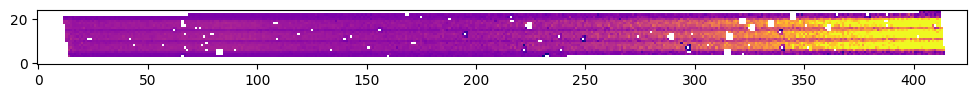

2025-01-16 13:06:55,460 - stpipe.BarShadowStep - INFO - BarShadowStep instance created.
2025-01-16 13:06:55,470 - stpipe.BarShadowStep - INFO - BarShadowStep instance created.
2025-01-16 13:06:55,566 - stpipe.BarShadowStep - INFO - Step BarShadowStep running with args (<MultiSlitModel from jw01345063001_03101_00001_nrs1_cal.fits>,).
2025-01-16 13:06:55,567 - stpipe.BarShadowStep - INFO - Step BarShadowStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  inverse: False
  source_type: UNIFORM
2025-01-16 13:06:55,581 - stpipe.BarShadowStep - INFO - Using BARSHADOW reference file /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS/references/jwst/nirspec/jwst_nirspec_barshadow_0006.fits
2025-01-16 13:06:55,662 - stpipe.BarShadowStep - INFO - Working on slitlet 200
2025-01-1

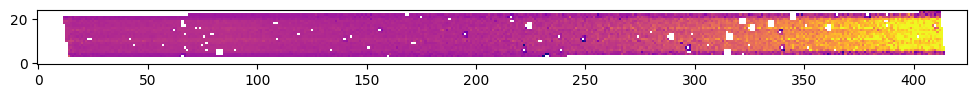

<class 'stdatamodels.properties.ObjectNode'>


In [11]:
from jwst.barshadow import BarShadowStep

cal = dm.open(directory+"NoSub/jw01345063001_03101_00001_nrs1_cal.fits")

plt.figure(figsize=(12,4))
z1, z2 = ZScaleInterval().get_limits(cal.slits[0].data)
plt.imshow(cal.slits[0].data, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
plt.show()

ratio = cal.slits[0].data

cal = BarShadowStep().call(cal, source_type="UNIFORM")

plt.figure(figsize=(12,4))
z1, z2 = ZScaleInterval().get_limits(cal.slits[0].data)
plt.imshow(cal.slits[0].data, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
plt.show()

print(type(cal.slits[0]))


In [ ]:
from BNBG.Pipeline.BetterBackgroundSubtractStep import modelBackgroundFromSlit

model, err = modelBackgroundFromSlit(cal.slits[0], n=0.05)
mask = np.isnan(cal.slits[0].data)
model[mask] = np.nan

plt.figure(figsize=(18,3))
z1, z2 = ZScaleInterval().get_limits(model)
plt.imshow(model, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
plt.show()

In [ ]:
from jwst.barshadow import BarShadowStep

bkg = cal.copy()
bkg.slits[0].data = model
bkg = [bkg, BarShadowStep().call(bkg, inverse=True, source_type="EXTENDED")]


In [ ]:
%matplotlib inline

# Clean, Barashadow
for _ in bkg:
	plt.figure(figsize=(16,1))
	z1, z2 = ZScaleInterval().get_limits(_.slits[0].data)
	plt.imshow(_.slits[0].data, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
	plt.colorbar()
	plt.show()

cal = dm.open(directory+"NoSub/jw01345063001_03101_00001_nrs1_cal.fits")

# Raw
plt.figure(figsize=(16,1))
z1, z2 = ZScaleInterval().get_limits(cal.slits[0].data)
plt.imshow(cal.slits[0].data, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
plt.colorbar()
plt.show()

# Residual
residual = cal.slits[0].data - bkg[-1].slits[0].data

plt.figure(figsize=(16,1))
z1, z2 = ZScaleInterval().get_limits(residual)
plt.imshow(residual, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
plt.colorbar()
plt.show()


In [ ]:
from scipy.ndimage import shift

%matplotlib Qt5Agg

data = cal.slits[0].data
background = bkg[0].slits[0].data
barshadow = bkg[1].slits[0].barshadow

_, ax = plt.subplots(2,1,figsize=(14,5))
plt.subplots_adjust(bottom=0.2)
ax_slider = plt.axes((0.2, 0.1, 0.6, 0.03))
slider = Slider(ax_slider, 'Shift', 0, data.shape[0], valinit=0, valstep=0.01)


def update(val):
	ax[0].clear()
	ax[1].clear()

	c = slider.val
	barshadow[np.isnan(barshadow)] = 0
	_ = shift(barshadow, (c, 0), mode='grid-wrap')
	_ = background*_
	img = data-_
	z1, z2 = ZScaleInterval().get_limits(img)
	ax[1].imshow(data, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)

	z1, z2 = 3.7990356e-14, 8.461599879650386e-13
	ax[0].imshow(_, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)

update(0)

# Attach the update function to the slider
slider.on_changed(update)

plt.show()
